# Featherstone Report

## Line Overview

93/94: Extruders + Thermoformers

95/96/97 Ex only

61/62/63/64 TF only

31/32/33/34 Convenience Lines

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

plt.rcParams.update({'figure.max_open_warning': 0})
pd.set_option('mode.chained_assignment', None)
pd.options.display.max_rows = 20
pd.set_option("display.max_columns", 50)

In [2]:
# import oee data
master_oee = pd.read_csv('../data/kp_films/oee.csv', low_memory=False)
master_oee["To Date/Time"] = pd.to_datetime(master_oee["To Date/Time"]) #resolve datetimes
master_oee["From Date/Time"] = pd.to_datetime(master_oee["From Date/Time"])

# import downtime data
master = pd.read_csv('../data/kp_films/downtimes.csv', low_memory=False)
master["Accountable From Date"] = pd.to_datetime(master["Accountable From Date"])
master["Accountable To Date"] = pd.to_datetime(master["Accountable To Date"])
master["Duration"] = (master["Accountable To Date"] - master["Accountable From Date"]).dt.total_seconds()/60/60

# import oee data with User / Product
rate_analysis = pd.read_csv('../data/kp_films/featherstone_oee_with_user.csv', low_memory=False)
rate_analysis["To Date/Time"] = pd.to_datetime(rate_analysis["To Date/Time"])
rate_analysis["From Date/Time"] = pd.to_datetime(rate_analysis["From Date/Time"])
rate_analysis["Scheduled Time"] = pd.to_timedelta(rate_analysis["Scheduled Time"])
rate_analysis["Run Time"] = pd.to_timedelta(rate_analysis["Run Time"])

# compute basic metrics
rate_analysis["Rate"] = rate_analysis["Net Quantity Produced"] / (rate_analysis["Run Time"].dt.total_seconds()/60/60)
rate_analysis["Yield"] = rate_analysis["Quantity Good"] / rate_analysis["Net Quantity Produced"]
rate_analysis["Unscheduled Downtime"] = (rate_analysis["Scheduled Time"] -\
                                         rate_analysis["Run Time"]).dt.total_seconds()/60/60

# Asset Capability: Rates, Yields, Downtimes by Line by Product

In [3]:
### Compare unplanned downtime v.s. scheduled - actual
downtime_comparison = np.zeros((2,master.Line.unique().shape[0]))
for index, line in enumerate(master.Line.unique()):
    current = rate_analysis
    runtime_unplanned = pd.to_timedelta(current.loc[(current["From Date/Time"] > datetime.datetime(year=2019, month=1, day=1)) &
                (current["To Date/Time"] < datetime.datetime(year=2020, month=1, day=1)) & 
                   (current["Line"] == line)]["Scheduled Time"]).sum() - \
    pd.to_timedelta(current.loc[(current["From Date/Time"] > datetime.datetime(year=2019, month=1, day=1)) &
                (current["To Date/Time"] < datetime.datetime(year=2020, month=1, day=1)) & 
                               (current["Line"] == line)]["Run Time"]).sum()

    downtime_unplanned = (master.loc[(master["Accountable From Date"] > datetime.datetime(year=2019, month=1, day=1)) &
                (master["Accountable To Date"] < datetime.datetime(year=2020, month=1, day=1)) &
                (master["Line"] == line) &
                (master["Stop Category"] != "Planned")]["Duration"]/24).sum()
    downtime_comparison[0, index] = runtime_unplanned.total_seconds()/60/60/24
    downtime_comparison[1, index] = downtime_unplanned
df = pd.DataFrame(downtime_comparison).T
df.index = master.Line.unique()
df.columns = [["Total Down Days, OEE Dataset", "Total Down Days, Downtime Dataset"]]

Downtime logging correlates between datasets but does not agree exactly for lines other than 95, 96, 97

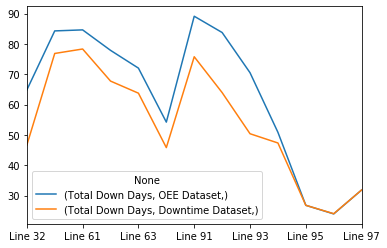

In [4]:
df.plot()

In [5]:
current = rate_analysis
class AssetCapability():
    """
    Class for determining asset capability based on historical yields, rates, and downtimes
    """
    
    def filter(self,
               data,
               yaxis = "Yield",
               groupby = 'Product',
               line = 'Line 94',
               product = None,
               minn = 0.01,
               maxx = 0.99,
               top_filter = 30,
               res = True,
               cut = 10):
        """
        Data processing based on outliers. Performance is categorized on line and 'groupby'
        parameter basis.
        
        Parameters
        ----------
        data: DataFrame
            line production DataFrame
        yaxis: str
            options: "Rate", "Yield", "Unscheduled Downtime", "Net Quantity Produced"
            default: "Yield"
        groupby: str
            options: "Product", "User"
            default: "Product"
        product: str
            options: any product string appearing in the dataframe. default: None
            will return performance based on single product
        minn: float
            bottom quintile
        maxx: float
            upper quintile
        top_filter: int
            default: 30
            return only metrics for upper 'groupby' 
        res: boolean
            default: True
            whether to return analysis with quintile filters
        cut: int
            default: 10
            return only performance for 'groupby' with > cut
            
        Returns
        -------
        self
            the resulting filtered DataFrame
        """
        
        current = data
        current = current.loc[(current[yaxis] <= np.inf) &
                    (current[yaxis] != np.inf)] #screen inf
        if res:
            res = current.groupby(groupby)[yaxis].quantile([minn, maxx]).unstack(level=1)
        if yaxis == "Yield":
            current = current.loc[(current[yaxis] <= 1)]
        if product:
            current = current.loc[(rate_analysis["Product"] == product)]
        if line:
            current = current.loc[(rate_analysis["Line"] == line)]
        if cut:
            current = current.groupby(groupby).filter(lambda x : (x[groupby].count()>=cut).any())
        if top_filter:
            current = current.loc[current[groupby].isin(current.groupby(groupby)[yaxis].count().sort_values(ascending=False).index[:top_filter])]
        if res is not None:
            current = current.loc[((res.loc[current[groupby], minn] < current[yaxis].values) & (current[yaxis].values < res.loc[current[groupby], maxx])).values]
        
        self.current = current
        self.yaxis = yaxis
        self.groupby = groupby
        self.line = line
            
    def opportunity_table(self):
        """
        Returns
        -------
        self
            resulting table with performance metrics
        """
        current = self.current
        yaxis = self.yaxis
        groupby = self.groupby
        line = self.line
        df = current.groupby(groupby)[yaxis].describe().sort_values(by='mean', ascending=False)#.to_excel('Production Rate, {}, top 30 Products.xlsx'.format(line))
        df_prod = current.loc[(current["From Date/Time"] > datetime.datetime(year=2019, month=1, day=1)) &
                    (current["To Date/Time"] < datetime.datetime(year=2020, month=1, day=1))].groupby(groupby)['Net Quantity Produced'].sum()
        df_time = current.loc[(current["From Date/Time"] > datetime.datetime(year=2019, month=1, day=1)) &
                    (current["To Date/Time"] < datetime.datetime(year=2020, month=1, day=1))].groupby(groupby)['Run Time'].sum()
        dff = pd.merge(df, df_prod, left_index=True, right_index=True)
        dff = pd.merge(dff, df_time, left_index=True, right_index=True)
        
        self.table = dff
        self.table.name = 'metric: {}, by: {}, for: {}'.format(yaxis, groupby, line)

In [6]:
asset_metric = 'Rate'
line = "Line 95"
groupby = 'Product'
analysis = AssetCapability()
analysis.filter(rate_analysis, 
                line=line, 
                groupby=groupby,
                minn=0.01,
                maxx=0.83,
                top_filter=30,
                cut=3,
                yaxis=asset_metric)
analysis.opportunity_table()
print(analysis.table.name)

dff = analysis.table
yaxis = analysis.yaxis
metric = "max"
T1 = (dff["Run Time"]).dt.total_seconds()/60/60/24
P1 = (dff["Net Quantity Produced"])
if yaxis == "Rate":
    R1 = dff["50%"]
    R2 = dff[metric]
    dayssaved = ((dff["Net Quantity Produced"] / dff["50%"] / 24) - (dff["Net Quantity Produced"] / dff[metric] / 24)).sum()
    additionalproduction = ((R2-R1)*24 * T1).sum()
elif yaxis == "Yield":
    T2 = ((dff["Run Time"] * dff["mean"] / dff[metric])).dt.total_seconds()/60/60/24
    P2 = (dff["Net Quantity Produced"] * dff[metric]).sum()
    P1 = (dff["Net Quantity Produced"] * dff["50%"]).sum()
    dayssaved = (T1 - T2).sum()
    additionalproduction = P2 - P1
elif yaxis == "Unscheduled Downtime":
    if metric == "75%":
        metric = "25%"
    elif metric == "max":
        metric = "min"
    sched_time = dff["Run Time"] / (1 - dff["50%"])
    T2 = (sched_time * (1 - dff[metric])).dt.total_seconds()/60/60/24
    dayssaved = (T2 - T1).sum()
    P1 = (dff["Net Quantity Produced"])
    P2 = (T2 * P1 / T1)
    additionalproduction = (P2 - P1).sum()
elif yaxis == "Net Quantity Produced":
    additionalproduction = P1.sum()
    dayssaved = T1.sum()

print("additional runtime (days): {:.2f}".format(dayssaved))
print("additional production (kg): {:.2f}".format(additionalproduction))
print("additional production (%): {:.2f}".format(additionalproduction / P1.sum() * 100))
print('')

metric: Rate, by: Product, for: Line 95
additional runtime (days): 29.13
additional production (kg): 779815.40
additional production (%): 25.95



Plotting the results from analysis.filter() provides us the distributions:

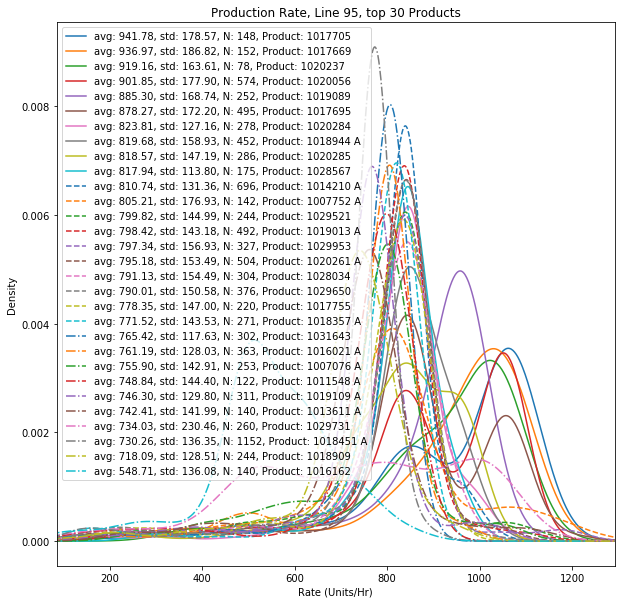

In [7]:
current = analysis.current
yaxis = asset_metric
fig, ax = plt.subplots(1,1,figsize=(10,10))  
for i, user in enumerate(current.groupby(groupby)[yaxis].mean().sort_values(ascending=False).index):
    N = current.loc[current[groupby] == user].shape[0]
    mean = current.loc[current[groupby] == user][yaxis].mean()
    std = current.loc[current[groupby] == user][yaxis].std()
    if i < 10:
        current.loc[current[groupby] == user][yaxis].plot.kde(ax=ax, label="avg: {:.2f}, std: {:.2f}, N: {}, {}: {}".format(mean, std, N, groupby, user))
    elif i < 20:
        current.loc[current[groupby] == user][yaxis].plot.kde(ax=ax, label="avg: {:.2f}, std: {:.2f}, N: {}, {}: {}".format(mean, std, N, groupby, user), ls='--')
    elif i < 30:
        current.loc[current[groupby] == user][yaxis].plot.kde(ax=ax, label="avg: {:.2f}, std: {:.2f}, N: {}, {}: {}".format(mean, std, N, groupby, user), ls='-.')
    else:
        current.loc[current[groupby] == user][yaxis].plot.kde(ax=ax, label="avg: {:.2f}, std: {:.2f}, N: {}, {}: {}".format(mean, std, N, groupby, user), ls=':')
ax.set_xlim(min(current[yaxis])*.95, max(current[yaxis]*1.05))
if asset_metric == "Yield":
    ax.set_xlim(0, 1.1)
    ax.set_xlabel('Yield (Net Good/Net Produced)')
    plt.title('Production Yield, {}, top 30 Products'.format(line))#{}: {}, grouped by {}'.format(line, groupby, product, groupby))
elif asset_metric == "Rate":
    ax.set_xlabel('Rate (Units/Hr)')
    plt.title('Production Rate, {}, top 30 Products'.format(line))#{}: {}, grouped by {}'.format(line, groupby, product, groupby))
plt.legend()
# fig.savefig('../figures/kp_featherstone/final_assessment/Production Yield, {}, top 30 Products'.format(line))#Production_Rate_{}_Product_{}_grouped_by_{}_greater_than_{}_data_points_for_user.png'.format(line, product, groupby, cut))

In the following, we compute asset capabilities based on:
* p90 (0.9 upper quintile) 
* product (groupby product)
* rate, yield, downtime, (columns in the rate_analysis DataFrame)

**These Performance Metrics can return additional capacity in terms of either time or production**

* For production capacity - computed based on time held constant, metrics other than the current held constant
* For time capacity - computed based on production held constant, metrics other than the current held constant

"Net Quantity Produced" not a performance metric - historical sum of products produced for comparison

Note:

MAC calculation only works for Rate

In [8]:
metrics = ["Rate", "Yield", "Unscheduled Downtime", "Net Quantity Produced"]
pareto = np.zeros((rate_analysis.Line.unique().shape[0], len(metrics)))
mac = np.zeros((rate_analysis.Line.unique().shape[0], len(metrics)))
for outer, asset_metric in enumerate(metrics):
    print(asset_metric)
    for inner, line in enumerate(rate_analysis.Line.unique()):
        analysis = AssetCapability()
        analysis.filter(rate_analysis, 
                        line=line, 
                        minn=0.1,
                        maxx=0.9,
                        top_filter=None,
                        cut=3,
                        yaxis=asset_metric)
        analysis.opportunity_table()
        print(analysis.table.name)

        dff = analysis.table
        yaxis = analysis.yaxis
        metric = "max"
        T1 = (dff["Run Time"]).dt.total_seconds()/60/60/24
        P1 = (dff["Net Quantity Produced"])
        if yaxis == "Rate":
            R1 = dff["50%"]
            R2 = dff[metric]
            dayssaved = ((dff["Net Quantity Produced"] / dff["50%"] / 24) - (dff["Net Quantity Produced"] / dff[metric] / 24)).sum()
            additionalproduction = ((R2-R1)*24 * T1).sum()
        elif yaxis == "Yield":
            T2 = ((dff["Run Time"] * dff["mean"] / dff[metric])).dt.total_seconds()/60/60/24
            P2 = (dff["Net Quantity Produced"] * dff[metric]).sum()
            P1 = (dff["Net Quantity Produced"] * dff["50%"]).sum()
            
            dayssaved = (T1 - T2).sum()
            additionalproduction = P2 - P1
        elif yaxis == "Unscheduled Downtime":
            if metric == "75%":
                metric = "25%"
            elif metric == "max":
                metric = "min"
            sched_time = dff["Run Time"] / (1 - dff["50%"])
            T2 = (sched_time * (1 - dff[metric])).dt.total_seconds()/60/60/24
            dayssaved = (T2 - T1).sum()
            P1 = (dff["Net Quantity Produced"])
            P2 = (T2 * P1 / T1)
            additionalproduction = (P2 - P1).sum()
        elif yaxis == "Net Quantity Produced":
            additionalproduction = P1.sum()
            dayssaved = T1.sum()
        mac[inner, outer] = (dff[metric] * P1).sum() / P1.sum()
        pareto[inner, outer] = additionalproduction
pareto = pd.DataFrame(pareto)
pareto.columns = metrics
pareto.index = rate_analysis.Line.unique()
mac = pd.DataFrame(mac)
mac.columns = metrics
mac.index = rate_analysis.Line.unique()

pareto

Rate
metric: Rate, by: Product, for: Line 32
metric: Rate, by: Product, for: Line 33
metric: Rate, by: Product, for: Line 61
metric: Rate, by: Product, for: Line 62
metric: Rate, by: Product, for: Line 63
metric: Rate, by: Product, for: Line 64
metric: Rate, by: Product, for: Line 91
metric: Rate, by: Product, for: Line 92
metric: Rate, by: Product, for: Line 93
metric: Rate, by: Product, for: Line 94
metric: Rate, by: Product, for: Line 95
metric: Rate, by: Product, for: Line 96
metric: Rate, by: Product, for: Line 97
Yield
metric: Yield, by: Product, for: Line 32
metric: Yield, by: Product, for: Line 33
metric: Yield, by: Product, for: Line 61
metric: Yield, by: Product, for: Line 62
metric: Yield, by: Product, for: Line 63
metric: Yield, by: Product, for: Line 64
metric: Yield, by: Product, for: Line 91
metric: Yield, by: Product, for: Line 92
metric: Yield, by: Product, for: Line 93
metric: Yield, by: Product, for: Line 94
metric: Yield, by: Product, for: Line 95
metric: Yield, by:

,Rate,Yield,Unscheduled Downtime,Net Quantity Produced
Line 32,3.168058e+06,5.685857e+06,5.063123e+06,43297740.0
Line 33,7.088116e+06,5.467801e+06,7.058920e+06,48811967.0
Line 61,2.466911e+06,3.731713e+05,3.473145e+06,27170375.0
Line 62,4.457405e+06,2.293797e+06,4.263404e+06,16166624.0
Line 63,1.100762e+07,7.599839e+06,7.896366e+06,58661207.0
Line 64,1.223458e+06,1.116004e+06,1.366745e+06,6895027.0
Line 91,1.620834e+07,8.563017e+06,1.121275e+07,81154263.0
Line 92,1.631932e+07,6.716099e+06,1.029877e+07,66190389.0
Line 93,3.834225e+06,4.614285e+06,7.749291e+06,71130165.0
Line 94,6.332960e+06,7.621044e+06,8.580993e+06,108384855.0


In [9]:
pareto90_lowfilt = pareto
pareto90_lowfilt = pareto90_lowfilt.sort_values(by="Net Quantity Produced")
pareto90_lowfilt = pareto90_lowfilt[["Net Quantity Produced", "Rate", "Yield", "Unscheduled Downtime"]]

Note that lines 95, 96, and 97 are in different units

Text(0.5, 0, 'Production 2019 (kg)')

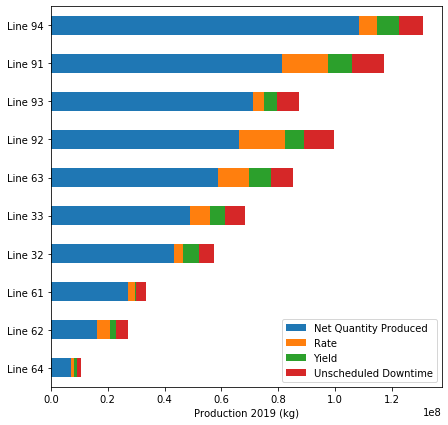

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))
pareto90_lowfilt.loc[pareto90_lowfilt.index.isin(pareto90_lowfilt.index[3:])].plot.barh(stacked=True, ax = ax)
ax.set_xlabel('Production 2019 (kg)')
# ax.get_legend().remove()
# fig.savefig('../figures/kp_featherstone/capacity_pareto_kg.png')

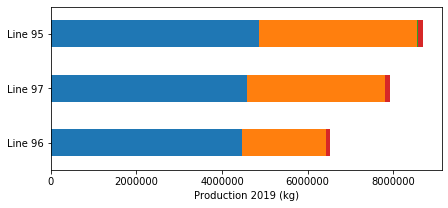

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(7,3))
pareto90_lowfilt.loc[pareto90_lowfilt.index.isin(pareto90_lowfilt.index[:3])].plot.barh(stacked=True, ax = ax)
ax.set_xlabel('Production 2019 (kg)')
ax.get_legend().remove()
# fig.savefig('../figures/kp_featherstone/capacity_pareto_kg.png')

In [12]:
mac.columns = mac.columns + " MAC"

In [8]:
metrics = pd.read_csv('../data/kp_films/oee_with_metrics', low_memory=False)
metrics["To Date/Time"] = pd.to_datetime(metrics["To Date/Time"])
metrics["From Date/Time"] = pd.to_datetime(metrics["From Date/Time"])

oee = pd.read_csv('../data/kp_films/featherstone_oee_with_user.csv', low_memory=False)
oee["To Date/Time"] = pd.to_datetime(oee["To Date/Time"])
oee["From Date/Time"] = pd.to_datetime(oee["From Date/Time"])
oee["Scheduled Time"] = pd.to_timedelta(oee["Scheduled Time"])
oee["Run Time"] = pd.to_timedelta(oee["Run Time"])

oee["Rate"] = oee["Net Quantity Produced"] / (oee["Run Time"].dt.total_seconds()/60/60)
oee["Yield"] = oee["Quantity Good"] / oee["Net Quantity Produced"]
oee["Utilization"] = oee["Scheduled Time"] / datetime.timedelta(hours=1)
oee["Uptime"] = oee["Run Time"] / oee["Scheduled Time"]
metric_cols = ["Rate", "Yield", "Uptime", "Utilization"]

# filters
oee.loc[(oee["Rate"] == np.inf) |
        (oee["Rate"] == 0), "Rate"] = np.nan # rates bounded: 0 < rate < inf
oee.loc[(oee["Yield"] == 0) |
        (oee["Yield"] > 1), "Yield"] = np.nan # yield bounded: 0 < yield < 1
oee.Uptime.fillna(inplace=True, value=0)
oee.index = oee["From Date/Time"]

metrics.loc[(metrics["Performance Efficiency %"] > 100) |
            (metrics["Performance Efficiency %"] == 0), "Performance Efficiency %"] = np.nan
metrics.loc[(metrics["Quality Rate %"] > 100) |
            (metrics["Quality Rate %"] == 0), "Quality Rate %"] = np.nan
metrics.loc[(metrics["Availability %"] > 100), "Availability %"] = np.nan
metrics.loc[(metrics["Asset Utilisation %"] > 100), "Asset Utilisation %"] = np.nan
metrics.loc[(metrics["OEE %"] > 100), "OEE %"] = np.nan
metrics.loc[(metrics["TEEP %"] > 100), "TEEP %"] = np.nan
oee.loc[oee["Scheduled Time"] == datetime.timedelta(seconds=0), "Uptime"] = np.nan


# energy
energy = pd.read_excel('../../klockner pentaplast/LineByLineEnergy.xlsx', sheet_name='Summary', index_col=0)
energy = energy.T
sum_cols = []
avg_cols = []
start = datetime.datetime(year=2019, month=1, day=1)
end = datetime.datetime(year=2020, month=1, day=1)
for col in metrics.columns:
    if "#" in col:
        sum_cols.append(col)
    elif "%" in col:
        avg_cols.append(col)
avgs = metrics.loc[(metrics["From Date/Time"] > start) &
               (metrics["To Date/Time"] < end)].groupby("Line")[avg_cols].mean()
sums = metrics.loc[(metrics["From Date/Time"] > start) &
               (metrics["To Date/Time"] < end)].groupby("Line")[sum_cols].sum()
produced = oee.loc[(oee["From Date/Time"] > start) &
               (oee["To Date/Time"] < end)].groupby("Line")[["Total Inventory Produced",
                                                             "Net Quantity Produced",
                                                             "Quantity Good"]].sum()
metrix = oee.loc[(oee["From Date/Time"] > start) &
               (oee["To Date/Time"] < end)].groupby("Line")[metric_cols].mean()
# Run Time 2019
rtime = oee.loc[(oee["From Date/Time"] > start) &
                          (oee["From Date/Time"] < end)].groupby('Line')["Run Time"].sum().sort_values()
# Scheduled Time 2019
stime = oee.loc[(oee["From Date/Time"] > start) &
                          (oee["From Date/Time"] < end)].groupby('Line')["Scheduled Time"].sum().sort_values()
df = pd.merge(avgs, produced, left_index=True, right_index=True)
df = pd.merge(df, rtime, left_index=True, right_index=True)
df = pd.merge(df, stime, left_index=True, right_index=True)
df = pd.merge(df, metrix, left_index=True, right_index=True)
# df = pd.merge(df, energy, left_index=True, right_index=True)
# df.to_excel('../data/kp_films/line_summary.xlsx')
df = pd.merge(df, mac["Rate MAC"], left_index=True, right_index=True)
df["Rate Performance"] = df["Rate"] / df["Rate MAC"]

quantities = [col for col in oee.columns if 'Quantity' in col]
print(quantities)

/home/wab665/anaconda3/envs/py37/lib/python3.8/site-packages/pandas/core/arrays/timedeltas.py:597: RuntimeWarning: invalid value encountered in true_divide
  return other / self._data


NameError: name 'mac' is not defined

In [9]:
metrics

,Line,From Date/Time,To Date/Time,# Runs,# Shifts,# Crews,Availability %,Performance Efficiency %,Quality Rate %,OEE %,Asset Utilisation %,TEEP %
0,Line 32,2017-01-01 07:00:00,2017-01-01 08:00:00,1,1,1,0.0,NaN,NaN,0.0,0.0,0.0
1,Line 32,2017-01-01 08:00:00,2017-01-01 09:00:00,1,1,1,0.0,NaN,NaN,0.0,0.0,0.0
2,Line 32,2017-01-01 09:00:00,2017-01-01 10:00:00,1,1,1,0.0,NaN,NaN,0.0,0.0,0.0
3,Line 32,2017-01-01 10:00:00,2017-01-01 11:00:00,1,1,1,0.0,NaN,NaN,0.0,0.0,0.0
4,Line 32,2017-01-01 11:00:00,2017-01-01 12:00:00,1,1,1,0.0,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
333845,Line 97,2020-01-21 04:00:00,2020-01-21 05:00:00,1,1,1,0.0,NaN,NaN,0.0,0.0,0.0
333846,Line 97,2020-01-21 05:00:00,2020-01-21 06:00:00,1,1,1,0.0,NaN,NaN,0.0,0.0,0.0
333847,Line 97,2020-01-21 06:00:00,2020-01-21 07:00:00,1,1,1,0.0,NaN,NaN,0.0,0.0,0.0
333848,Line 97,2020-01-21 07:00:00,2020-01-21 08:00:00,1,1,1,0.0,NaN,NaN,0.0,0.0,0.0


In [14]:
# add OEE / TEEP
df["OEE"] = df["Rate Performance"] * df["Uptime"] * df["Yield"]
df["TEEP"] = df["OEE"] * df["Utilization"]

% metrics are from client, these generally disagree with the computed metrics (client sets arbirtary MAC, combines utilization + availability, etc.)

In [15]:
df.sort_values("OEE")

,Availability %,Performance Efficiency %,Quality Rate %,OEE %,Asset Utilisation %,TEEP %,Total Inventory Produced,Net Quantity Produced,Quantity Good,Run Time,Scheduled Time,Rate,Yield,Uptime,Utilization,Rate MAC,Rate Performance,OEE,TEEP
Line,,,,,,,,,,,,,,,,,,,
Line 64,21.310255,90.965069,84.592062,13.868667,19.971910,13.902864,13847660.0,14610125.0,13847660,72 days 20:32:30,127 days 02:01:16,8213.013460,0.845921,0.583582,0.348375,10746.565609,0.764245,0.377281,0.131435
Line 62,31.329543,94.351380,81.210280,18.425063,29.867963,18.494196,25605106.0,27114671.0,25605106,108 days 22:56:19,186 days 20:13:29,10448.946083,0.811940,0.590760,0.512190,12824.782391,0.814746,0.390803,0.200165
Line 91,70.269227,88.046006,79.621938,52.709272,69.776114,52.664103,84081623.0,92871228.0,84081623,254 days 13:46:47,343 days 16:48:45,15201.714821,0.795856,0.740321,0.942183,18937.263914,0.802741,0.472966,0.445621
Line 63,52.227160,93.817383,81.183156,36.919498,51.110142,37.054048,82766112.0,84331066.0,82766112,186 days 11:32:31,258 days 12:06:56,18701.791979,0.811918,0.723037,0.708637,23119.501973,0.808918,0.474873,0.336513
Line 92,68.239166,88.695823,80.848384,52.329718,67.547280,52.211790,72040386.0,78931851.0,72040386,246 days 10:41:16,330 days 05:02:19,13385.950352,0.808084,0.746886,0.905201,16844.557707,0.794675,0.479623,0.434156
Line 61,57.908820,93.508301,86.412125,17.764866,56.881372,17.775698,35536272.0,37869095.0,35536272,207 days 12:47:47,292 days 03:57:10,7655.238653,0.863679,0.710769,0.800908,9458.748893,0.809329,0.496828,0.397914
Line 33,64.831608,93.254128,79.848782,47.050801,63.949652,47.044487,53573940.0,57096435.0,53573940,233 days 07:29:41,317 days 14:32:13,10168.094364,0.798377,0.735139,0.870650,11805.771502,0.861282,0.505501,0.440114
Line 32,53.575326,96.466574,79.267167,36.578079,52.495042,36.544481,51288003.0,54682553.0,51288003,191 days 11:56:19,256 days 07:25:47,11920.030098,0.792711,0.747731,0.702619,12721.259370,0.937017,0.555402,0.390236
Line 93,72.516115,87.264270,83.047307,55.742065,71.929717,56.040523,78975501.0,83383770.0,78975501,262 days 10:07:08,332 days 22:23:55,13310.637627,0.830525,0.788375,0.912667,14303.590827,0.930580,0.609311,0.556098


computed quantity good and net quantity produced from 2017-2020

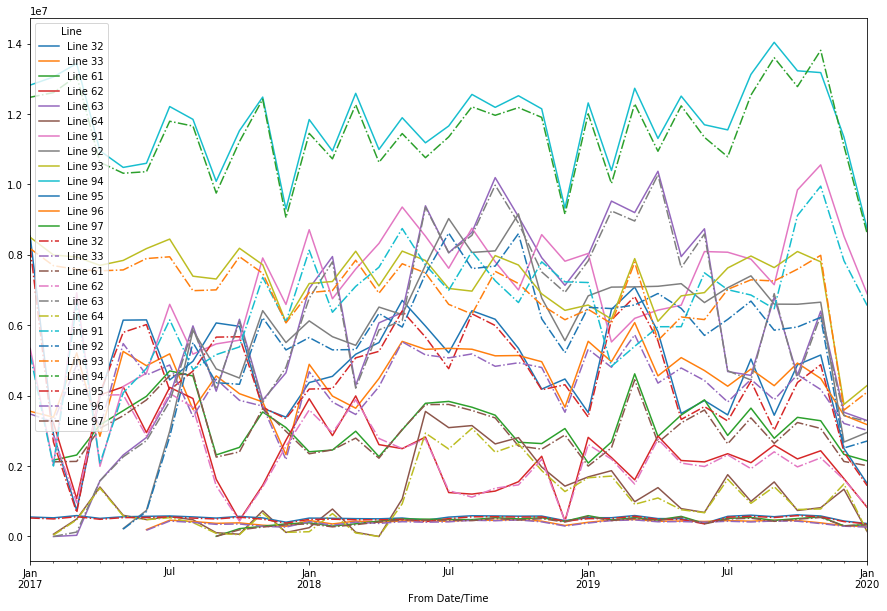

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))
oee.groupby("Line").resample('M')[quantities].sum().unstack()[quantities[0]].T.plot(ls='-', ax=ax)
oee.groupby("Line").resample('M')[quantities].sum().unstack()[quantities[2]].T.plot(ls='-.', ax=ax)

change timedelta to: "Y", "M", "W", "D" 

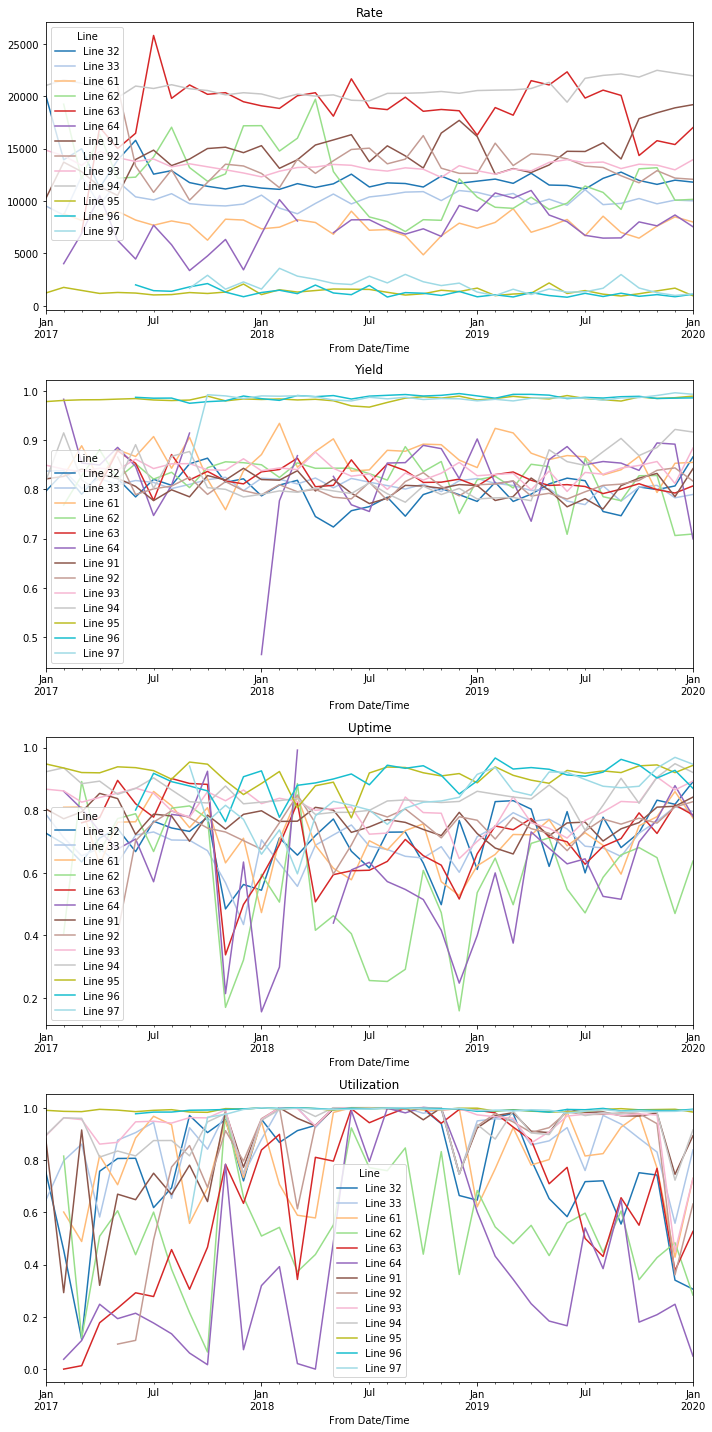

In [17]:
fig, axs = plt.subplots(4,1,figsize=(10,20))
timedelta = 'M'
oee.groupby("Line")[metric_cols].resample(timedelta).mean().unstack()["Rate"].T.plot(cmap='tab20', ax=axs[0])
oee.groupby("Line")[metric_cols].resample(timedelta).mean().unstack()["Yield"].T.plot(cmap='tab20', ax=axs[1])
oee.groupby("Line")[metric_cols].resample(timedelta).mean().unstack()["Uptime"].T.plot(cmap='tab20', ax=axs[2])
oee.groupby("Line")[metric_cols].resample(timedelta).mean().unstack()["Utilization"].T.plot(cmap='tab20', ax=axs[3])
axs[0].set_title('Rate')
axs[1].set_title('Yield')
axs[2].set_title('Uptime')
axs[3].set_title('Utilization')
plt.tight_layout()

# Pareto Downtime Categories / Reasons

Text(0.5, 1.0, 'Top 20 Downtime Categories')

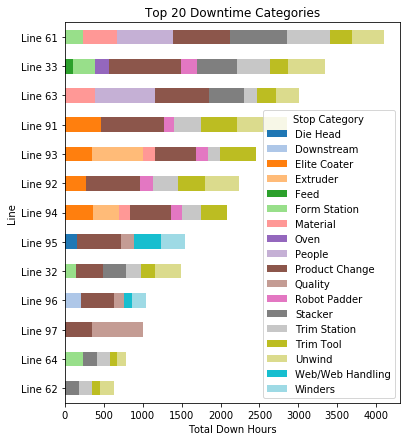

In [18]:
new_df = master.loc[(~master["Stop Category"]\
                     .isin(["[None]", "Planned"]))]\
                     .groupby(['Line','Stop Category'], sort=True)\
                     .filter(lambda x : (x['Duration']\
                     .count()>=300).any())

new_df = new_df.groupby(['Line','Stop Category'],
                        sort=True)["Duration"].sum().unstack()
cols = new_df.columns
new_df["Total"] = new_df.sum(axis=1)
new_df.sort_values(by='Total', inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(6,7))
new_df[cols].plot.barh(stacked=True, ax=ax, colormap='tab20')
ax.set_xlabel('Total Down Hours')
plt.title('Top 20 Downtime Categories')
# plt.savefig('../figures/kp_featherstone/top20downtime.png')

Text(0.5, 1.0, 'Planned Downtime')

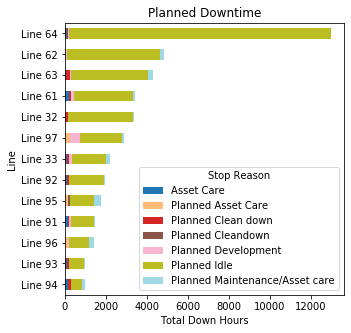

In [19]:
new_df = master.loc[(master["Stop Category"].isin(["Planned"]))].groupby(['Line','Stop Reason'], sort=True).filter(lambda x : (x['Duration'].count()>=10).any())
new_df = new_df.groupby(['Line','Stop Reason'], sort=True)["Duration"].sum().unstack()
cols = new_df.columns
new_df["Total"] = new_df.sum(axis=1)
new_df.sort_values(by='Total', inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(5,5))
new_df[cols].plot.barh(stacked=True, ax=ax, colormap='tab20')
ax.set_xlabel('Total Down Hours')
plt.title('Planned Downtime')
# plt.savefig('../figures/kp_featherstone/top20planned.png')

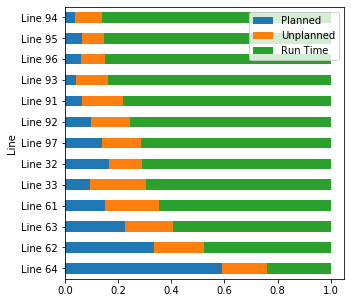

In [20]:
planned = master.loc[(master["Stop Category"]\
                      .isin(["Planned"]))]\
                      .groupby(['Line'])["Duration"].sum()
unplanned = master.loc[~(master["Stop Category"]\
                         .isin(["Planned"]))]\
                         .groupby(['Line'])["Duration"].sum()
produced = rate_analysis.groupby("Line")["Run Time"]\
                        .sum().dt.total_seconds()/60/60
new_df = pd.merge(planned, unplanned, left_index=True, right_index=True)
new_df = pd.merge(new_df, produced, left_index=True, right_index=True)
new_df.columns = ["Planned", "Unplanned", "Run Time"]
new_df = new_df.div(new_df.sum(axis=1), axis=0)
fig, ax = plt.subplots(1, 1, figsize=(5,5))
new_df.sort_values(by='Run Time').plot.barh(stacked=True, ax=ax)#, colormap='tab10')
# fig.savefig('../figures/kp_featherstone/time_normalized_downtime.png')

To identify any errors I did the following 'sanity checks' -- numbers should roughly match for more indepth computed data (where we performed filtration, groupby, etc)

In [21]:
# Sanity Checks
start = datetime.datetime(year=2019, month=1, day=1)
end = datetime.datetime(year=2020, month=1, day=1)
# Run Time 2019
rtime = rate_analysis.loc[(rate_analysis["From Date/Time"] > start) &
                          (rate_analysis["From Date/Time"] < end)].groupby('Line')["Run Time"].sum().sort_values()
# Scheduled Time 2019
stime = rate_analysis.loc[(rate_analysis["From Date/Time"] > start) &
                          (rate_analysis["From Date/Time"] < end)].groupby('Line')["Scheduled Time"].sum().sort_values()
# production
prod = rate_analysis.loc[(rate_analysis["From Date/Time"] > start) &
                          (rate_analysis["From Date/Time"] < end)].groupby('Line')["Net Quantity Produced", "Quantity Good"].sum()
# rates
rates = prod["Net Quantity Produced"]/(rtime.dt.total_seconds()/60/60).sort_values()
rates = pd.DataFrame(rates)
rates.columns = ["Rate (kg/hr)"]
check = pd.merge(rtime, stime, left_index = True, right_index = True)
check = pd.merge(check, prod, left_index = True, right_index = True)
check = pd.merge(check, rates, left_index = True, right_index = True)
check["Yield"] = check["Quantity Good"] / check["Net Quantity Produced"]
check["Uptime"] = check["Run Time"] / check["Scheduled Time"]
check.sort_values('Rate (kg/hr)')
check.sort_values('Uptime')

,Run Time,Scheduled Time,Net Quantity Produced,Quantity Good,Rate (kg/hr),Yield,Uptime
Line,,,,,,,
Line 64,72 days 20:32:30,127 days 02:01:16,14610125.0,13847660,8355.605862,0.947813,0.573288
Line 62,108 days 22:56:19,186 days 20:13:29,27114671.0,25605106,10369.142467,0.944327,0.583142
Line 61,207 days 12:47:47,292 days 03:57:10,37869095.0,35536272,7603.020088,0.938398,0.710329
Line 63,186 days 11:32:31,258 days 12:06:56,84331066.0,82766112,18842.649013,0.981443,0.721383
Line 33,233 days 07:29:41,317 days 14:32:13,57096435.0,53573940,10196.711995,0.938306,0.734597
Line 91,254 days 13:46:47,343 days 16:48:45,92871228.0,84081623,15200.421655,0.905357,0.740686
Line 92,246 days 10:41:16,330 days 05:02:19,78931851.0,72040386,13345.057925,0.912691,0.746329
Line 32,191 days 11:56:19,256 days 07:25:47,54682553.0,51288003,11898.016407,0.937923,0.747133
Line 93,262 days 10:07:08,332 days 22:23:55,83383770.0,78975501,13239.472209,0.947133,0.788211


# Table of Products

which products can be produced on which lines

In [22]:
mast = pd.DataFrame()
cur = pd.DataFrame()
for index, line in enumerate(master.Line.unique()):
    prods = master.loc[master["Line"] == line]["Part"].unique()
    prev = cur
    cur = pd.DataFrame(prods)
    cur.columns = [line]
    
    if index == 0:
        mast = cur
    elif index > 0:
        mast = pd.merge(mast, cur, left_index=True, right_index=True, how='outer')

In [23]:
mast.head()
# mast.to_excel('lines_and_products.xlsx', index=False)

,Line 32,Line 33,Line 61,Line 62,Line 63,Line 64,Line 91,Line 92,Line 93,Line 94,Line 95,Line 96,Line 97
0,1013273,1019449,1016359 A,1020132,1016455,1016754 A,1013904,1020301,1018590,1019508,1011538 A,1019127,1011557 A
1,1016455,1019440 A,1019132,1027624,1027624,1014017,1012993,1019516,1018363,1015946,1017753,1019125,1019089
2,1017382 A,1019441 A,1019133,1017382 A,1018620,1006839,1019751,1017186,1019511,1015568,1007755 A,1015105 A,1013083
3,1006537 B,1019624,1018910,1016624,1016210 C,1015095,1019834,1013799,1019594,1015958 A,1019746 A,1016556 A,1017697
4,1018620,1019090,1016471,1016567 C,1029609,1016471,1016036 C,1007606,1019884,1019513,1019154,1007748 A,1018380 A


# Yield Distributions, By Line

In [24]:
totals = []
times = []
for col in master_oee.columns:
    if ("Total" in col) | ("Quantity" in col):
        totals.append(col)
    if  ("Scheduled Time" in col) | ("Run Time" in col):
        times.append(col)

In [25]:
master_oee = pd.read_csv('featherstone_oee_with_product_hourly_no_sched_down.csv', dtype={'Product': str})
master_oee["Scheduled Time"] = pd.to_timedelta(master_oee["Scheduled Time"])
master_oee["Run Time"] = pd.to_timedelta(master_oee["Run Time"])
master_oee.loc[(master_oee["Scheduled Time"] > datetime.timedelta(seconds=0))]

quantities = master_oee.groupby("WO#")[totals].sum()
schedtime = master_oee.groupby("WO#")["Scheduled Time"].sum()
runtime = master_oee.groupby("WO#")["Run Time"].sum()
start = master_oee.groupby("WO#")["From Date/Time"].first()
end = master_oee.groupby("WO#")["To Date/Time"].last()
availability = master_oee.groupby("WO#")["Availability %"].mean()
products = master_oee.groupby("WO#")["Product"].first()
lines = master_oee.groupby("WO#")["Line"].first()
current = pd.concat([start, end, products, availability, schedtime, runtime, quantities, lines], axis=1, sort=False)
df = current
df["Yield"] = df["Quantity Good"] / df["Net Quantity Produced"]

/home/wbeckner/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Text(0.5, 1.0, 'Yield Distribution, All Lines')

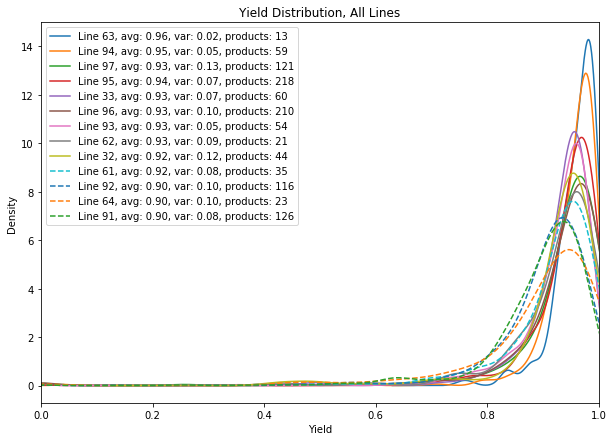

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
for index, line in enumerate(df.loc[(df["Yield"] < 1) &
       (df["Yield"] > 0)].groupby('Line')["Yield"].mean().sort_values(ascending=False).index):
    current = df.loc[(df["Line"] == line) &
                     (df["Yield"] <= 1) &
                     (df["Yield"] >= 0)]
    mean = current["Yield"].mean()
    products = current.Product.unique().shape[0]
    var = current.groupby("Product")["Yield"].mean().std() / current.groupby("Product")["Yield"].mean().mean()
    
    if index < 9:
        current["Yield"].plot.kde(ax=ax, label="{}, avg: {:.2f}, var: {:.2f}, products: {}".format(line, mean, var, products))
    else:
        current["Yield"].plot.kde(ax=ax, label="{}, avg: {:.2f}, var: {:.2f}, products: {}".format(line, mean, var, products), ls='--')
ax.set_xlim(0,1)
ax.set_xlabel('Yield')
plt.legend()
plt.title("Yield Distribution, All Lines")
# fig.savefig('../figures/kp_featherstone/kde_yields_all_lines.png')

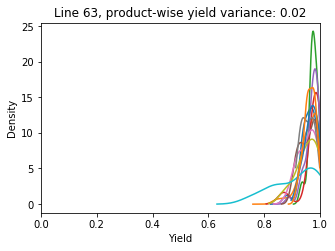

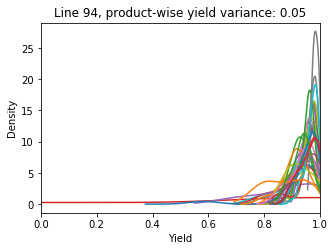

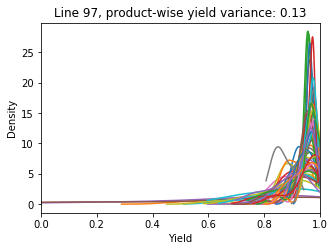

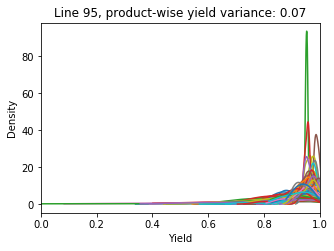

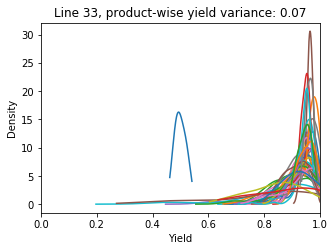

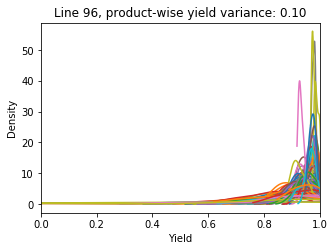

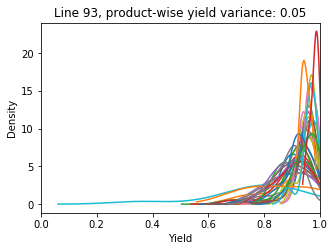

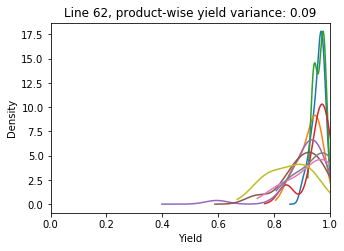

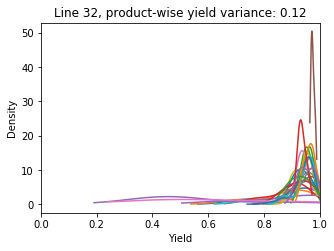

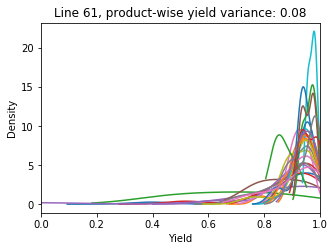

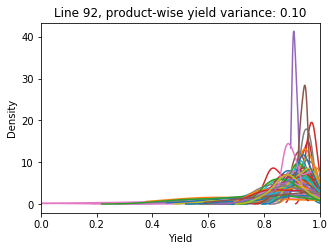

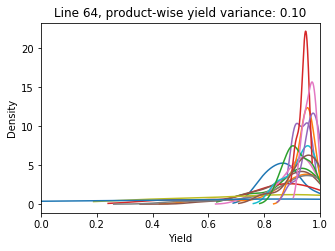

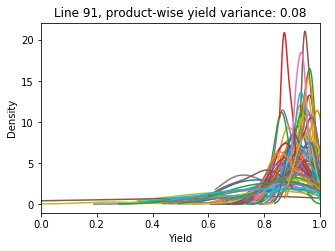

In [27]:
for line in df.loc[(df["Yield"] < 1) &
       (df["Yield"] > 0)].groupby('Line')["Yield"].mean().sort_values(ascending=False).index:
    fig, ax = plt.subplots(1, 1, figsize=(5, 3.5))
    current = df.loc[(df["Line"] == line) &
                     (df["Yield"] <= 1) &
                     (df["Yield"] >= 0)]
    product_wise_relative_variance = current.groupby("Product")["Yield"].mean().std() / current.groupby("Product")["Yield"].mean().mean()
    current.groupby('Product').filter(lambda x : (x['Product'].count()>=3).any()).groupby("Product")["Yield"].plot.kde(ax=ax)
    ax.set_xlim(0,1)
    plt.title("{}, product-wise yield variance: {:.2f}".format(line, product_wise_relative_variance))
    ax.set_xlabel("Yield")
#     fig.savefig('../figures/kp_featherstone/kde_yields_by_product_{}.png'.format(line))

# Part II, Drill Downs

### Downtime by Operator, Specific Reasons


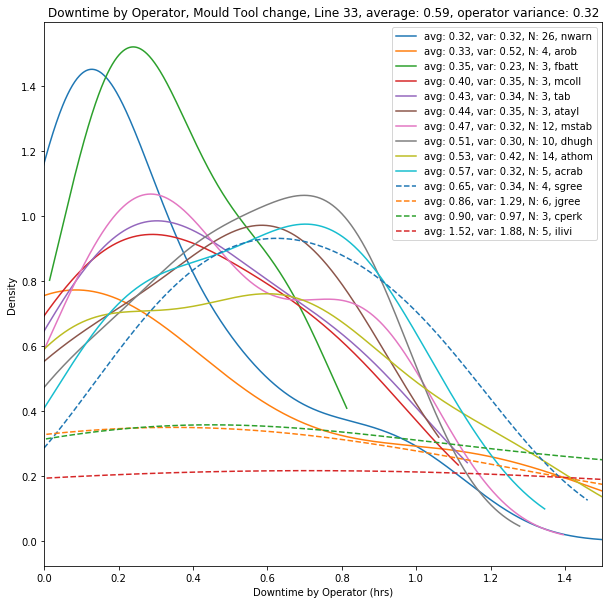

In [28]:
users = ['aric', 'phunt', 'smed', 'mclay', 'mstab', 'asho',
       'cward', 'edrze', 'atayl', 'pstea', 'shill', 'cara', 'scar',
       'jmiln', 'raut', 'mcoll', 'pemme', 'kburt', 'jgree', 'ilivi',
       'fbatt', 'jlang', 'padaw', 'ksko', 'nclam', 'pmyer', 'sgree',
       'gmcmi', 'pbugg', 'mruss', 'lcart', 'mmulv', 'srober', 'cguve',
       'kpark', 'lark', 'drob', 'ddick', 'jfitt', 'bradw', 'mcopl',
       'strue', 'nmar', 'dgarm', 'bkit', 'dspi', 'koski', 'jrudd',
       'lketc', 'tknei', 'rhenn', 'cperk', 'rworm', 'mpow', 'ahutt',
       'bproc', 'scart', 'dhugh', 'cmoor', 'mturt', 'mthom', 'arob',
       'jsaxb', 'jstai', 'ainman', 'kniem', 'mtull', 'tac', 'bmars',
       'balil', 'tcobb', 'amull', 'mhwil', 'taa', 'tab', 'tad', 'tande',
       'nwarn', 'pbeau', 'jfore', 'creid', 'vnich', 'athom', 'acrab',
       'tpayn', 'tcarr', 'mdula', 'cstai', 'jhaki', 'gridg', 'mvick',
       'bfox', 'pgood', 'jnadi', 'clowe', 'ssojk', 'svall', 'lpopk',
       'alaid', 'mkija', 'dconn', 'msmi', 'dholt', 'lmidd', 'mdanf',
       'kpenr', 'bthom', 'lking', 'aflor', 'dcorb', 'deade', 'ahalf',
       'ncleo', 'tboye', 'inich', 'rbeau', 'eeast', 'iston', 'kraw',
       'tmruk', 'gmil', 'amidd', 'jbart', 'dskar', 'lmach', 'tmart',
       'rshar', 'jsand', 'sdext', 'dsala', 'rston', 'srobe', 'lcarr',
       'arice', 'dmart', 'bworm', 'gmoon', 'wwaw', 'engn', 'dmorr',
       'phopk', 'nclar', 'tsmit', 'satk', 'alowe', 'mmach', 'aclar',
       'mwill', 'jcorm', 'dcorm', 'gedwa', 'gbrid', 'dcoa', 'lmalo',
       'rjohn', 'dmur', 'jnich', 'alane', 'middo', 'mturn', 'dlimb',
       'wbeau', 'sdavi', 'dkrze', 'cjoyc', 'icran', 'jnowa', 'temme',
       'amesh', 'idunn', 'nline', 'jstan']
line = 'Line 33'
cut=3
# for line in master.Line.unique():
category = "Product Change"
reason = "Mould Tool change"
current = master.loc[(master["Line"] == line) &
                     (master["Stop User"].isin(users)) &
                     (master["Stop Category"] == "Product Change") &
                     (master["Accountable From Date"] > datetime.datetime(year=2019, month=1, day=1))]
### reason filter
if reason:
    current = current.loc[current["Stop Reason"] == reason]

current = current.groupby('Stop User').filter(lambda x : (x['Stop User'].count()>=cut).any())
index = 0
master_plot = pd.DataFrame()
for user in current["Stop User"].unique():
    to_plot = current.loc[current["Stop User"] == user]
    innermean = to_plot["Duration"].mean()
    innerstd = to_plot["Duration"].std()
    to_plot["inner mean"] = innermean
    to_plot["inner std"] = innerstd
    master_plot = pd.concat([master_plot, to_plot])

if master_plot.shape[0] > 20:
    fig, ax = plt.subplots(1,1,figsize=(10,10))    
    for user in master_plot.groupby(["Stop User"])["Duration"].mean().sort_values().index:   
        to_plot = master_plot.loc[master_plot["Stop User"] == user]
        innermean = to_plot["Duration"].mean()
        innerstd = to_plot["Duration"].std()
        N = to_plot.shape[0]
        if index < 10:
            to_plot["Duration"].plot.kde(ax=ax, label="avg: {:.2f}, var: {:.2f}, N: {}, {}".format(innermean, innerstd, N, user))
        elif index < 20:
            to_plot["Duration"].plot.kde(ax=ax, label="avg: {:.2f}, var: {:.2f}, N: {}, {}".format(innermean, innerstd, N, user), ls='--')
        else:
            to_plot["Duration"].plot.kde(ax=ax, label="avg: {:.2f}, var: {:.2f}, N: {}, {}".format(innermean, innerstd, N, user), ls='-.')
        index += 1
    mean = current.groupby('Stop User').filter(lambda x : (x['Stop User'].count()>=cut).any()).groupby('Stop User')["Duration"].mean().mean()
    variance = current.groupby('Stop User').filter(lambda x : (x['Stop User'].count()>=cut).any()).groupby('Stop User')["Duration"].mean().std()
    ax.set_xlim(0,1.5)
    ax.set_xlabel('Downtime by Operator (hrs)')
    plt.title('Downtime by Operator, {}, {}, average: {:.2f}, operator variance: {:.2f}'.format(reason, line, mean, variance))
    plt.legend()
#     fig.savefig('../figures/kp_featherstone/final_assessment/kde_dt_by_reason_mould_tool_change_line_33.png')

# Thermoformer Tooling Downtime, by Product

In [29]:
master["Duration"] = (master["Accountable To Date"] - master["Accountable From Date"]).dt.total_seconds()/60/60

Text(0.5, 1.0, 'Downtime for Thermoformer')

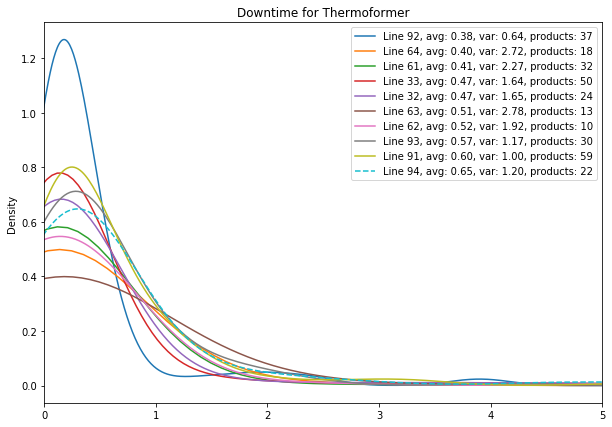

In [30]:
fig, ax = plt.subplots(1,1,figsize=(10, 7))
master["Duration"] = (master["Accountable To Date"] - master["Accountable From Date"]).dt.total_seconds()/60/60
for index, line in enumerate(master.loc[(master["Stop Category"] == "Form Station")].groupby('Line')["Duration"].mean().sort_values(ascending=True).index):
    current = master.loc[(master["Line"] == line) &
                         (master["Stop Category"] == "Form Station")]
    duration = (current["Accountable To Date"] - current["Accountable From Date"]).dt.total_seconds()/60/60
    products = current.Part.unique().shape[0]
    mean = duration.mean()
    var = duration.std()
    if index < 9:
        duration.plot.kde(ax=ax, label="{}, avg: {:.2f}, var: {:.2f}, products: {}".format(line, mean, var, products))
    else:
        duration.plot.kde(ax=ax, label="{}, avg: {:.2f}, var: {:.2f}, products: {}".format(line, mean, var, products), ls='--')
ax.set_xlim(0,5)
plt.legend()
plt.title("Downtime for Thermoformer")
# fig.savefig('../figures/kp_featherstone/kde_downtime_thermoformer_all_lines.png')

Text(0.5, 1.0, 'TF Downtime by Product, Line 32')

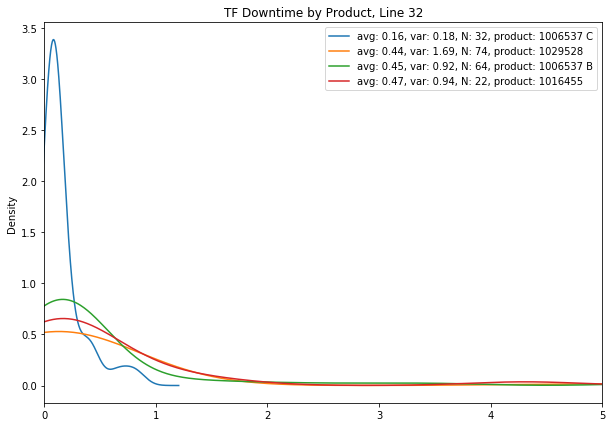

In [31]:
master["Duration"] = (master["Accountable To Date"] - master["Accountable From Date"]).dt.total_seconds()/60/60
line = "Line 32"
fig, ax = plt.subplots(1,1,figsize=(10, 7))
current = master.loc[(master["Line"] == line) &
                     (master["Stop Category"] == "Form Station")]

for product in current.groupby('Part').filter(lambda x : (x['Part'].count()>=3).any()).groupby("Part")["Duration"].mean().sort_values(ascending=True).index:
    duration = current.loc[current["Part"] == product]["Duration"]
    mean = duration.mean()
    var = duration.std()
    product_wise_relative_variance = current.groupby("Part")["Duration"].mean().std() #/ current.groupby("Part")["Duration"].mean().mean()
    N = duration.shape[0]
    if N > 15:

    #     if index < 9:
        current.loc[current["Part"] == product]["Duration"].plot.kde(ax=ax, label="avg: {:.2f}, var: {:.2f}, N: {}, product: {}".format(mean, var, N, product))
    #     else:
    #         current.groupby('Part').filter(lambda x : (x['Part'].count()>=3).any()).groupby("Part")["Duration"].plot.kde(ax=ax, label="{}, avg: {:.2f}, var: {:.2f}, products: {}".format(line, mean, var, products), ls='--')
ax.set_xlim(0,5)
plt.legend()
current = master.loc[(master["Line"] == line) &
                     (master["Stop Category"] == "Form Station")]
mean = current["Duration"].mean()
plt.title("TF Downtime by Product, {}".format(line))
# fig.savefig('../figures/kp_featherstone/kde_downtime_thermoformer_line_32.png')

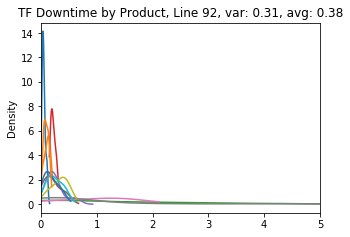

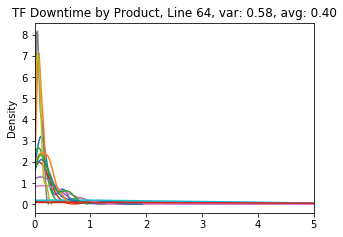

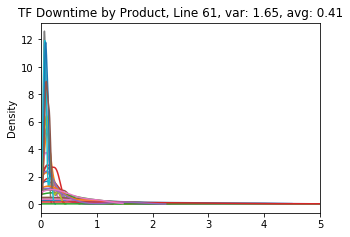

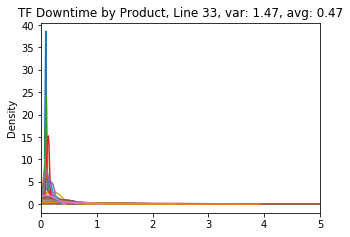

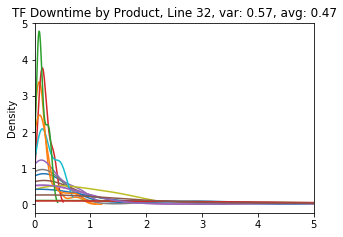

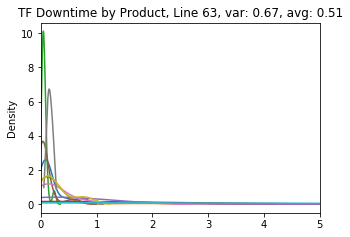

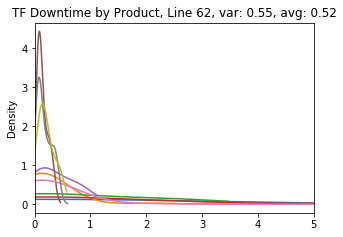

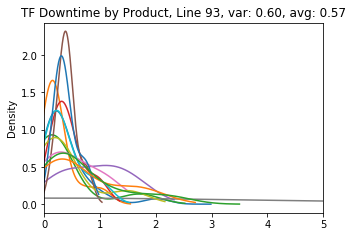

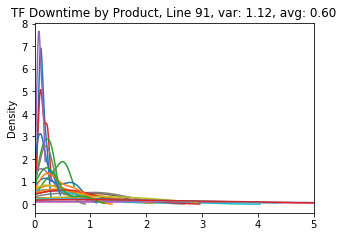

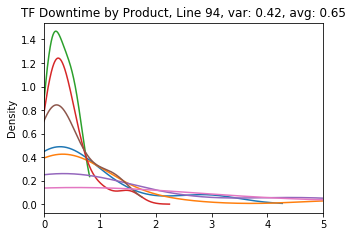

In [32]:
master["Duration"] = (master["Accountable To Date"] - master["Accountable From Date"]).dt.total_seconds()/60/60
for index, line in enumerate(master.loc[(master["Stop Category"] == "Form Station")].groupby('Line')["Duration"].mean().sort_values(ascending=True).index):
    fig, ax = plt.subplots(1,1,figsize=(5, 3.5))
    current = master.loc[(master["Line"] == line) &
                         (master["Stop Category"] == "Form Station")]
    duration = (current["Accountable To Date"] - current["Accountable From Date"]).dt.total_seconds()/60/60
    products = current.Part.unique().shape[0]
    mean = duration.mean()
    var = duration.std()
    product_wise_relative_variance = current.groupby("Part")["Duration"].mean().std() #/ current.groupby("Part")["Duration"].mean().mean()
#     if index < 9:
    current.groupby('Part').filter(lambda x : (x['Part'].count()>=3).any()).groupby("Part")["Duration"].plot.kde(ax=ax, label="{}, avg: {:.2f}, var: {:.2f}, products: {}".format(line, mean, var, products))
#     else:
#         current.groupby('Part').filter(lambda x : (x['Part'].count()>=3).any()).groupby("Part")["Duration"].plot.kde(ax=ax, label="{}, avg: {:.2f}, var: {:.2f}, products: {}".format(line, mean, var, products), ls='--')
    ax.set_xlim(0,5)
#     plt.legend()
    plt.title("TF Downtime by Product, {}, var: {:.2f}, avg: {:.2f}".format(line, product_wise_relative_variance, mean))
#     fig.savefig('../figures/kp_featherstone/kde_downtime_thermoformer_all_lines.png')

### Sweep - Find highest Variability through all Reasons - product-wise or user-wise

In [77]:
inner_var = 'part'
event.groupby(['reason', inner_var]).filter(lambda x : (x['hrs'].count()>=16).any())\
                        .groupby(['reason', inner_var])['hrs'].describe().sort_values(by='std')

count      mean       std       min  \
reason                        part                                             
Unknown                       1030465     21.0  0.004550  0.004069  0.000833   
                              1029201 A   17.0  0.003382  0.004373  0.000556   
                              1019023     47.0  0.003647  0.005219  0.000556   
                              1030044     55.0  0.004813  0.005325  0.000833   
                              1031303     21.0  0.008122  0.006468  0.000833   
                              1032456     32.0  0.008255  0.007090  0.000833   
                              1029119     56.0  0.005010  0.007232  0.000556   
                              1019199     17.0  0.008644  0.007318  0.000833   
                              1019025     47.0  0.004509  0.007523  0.000833   
                              1018791     31.0  0.005475  0.007677  0.000556   
...                                        ...       ...       ...       ...   
Planned Idle                  1016567 C   27.0  3.876060  5.835034  0.052778   
Deployed elsewhere (internal) 1018534 C   16.0  3.853785  5.848009  0.194722   
Planned Idle                  1014261 A   33.0  3.723636  5.876809  0.014167   
Deployed elsewhere (external) 1016210 C   21.0  3.053003  5.933460  0.053056   
Planned Idle                  1027624     55.0  3.597727  6.043004  0.005833   
Planned Development           1018545 C   19.0  2.538860  6.079055  0.051389   
Planned Idle                  1028414     23.0  2.460833  6.206746  0.051111   
No Sheet available            1020188 A   21.0  4.388968  6.310239  0.016667   
Deployed elsewhere (external) 1016455     29.0  4.202490  6.848253  0.016944   
Planned Idle                  1015095     20.0  5.466806  7.116913  0.088611   

                                              25%       50%       75%  \
reason                        part                                      
Unknown                       1030465    0.001111  0.001667  0.007500   
                              1029201 A  0.000833  0.000833  0.004444   
                              1019023    0.000972  0.001667  0.002917   
                              1030044    0.001389  0.002778  0.006389   
                              1031303    0.002222  0.008333  0.011111   
                              1032456    0.003472  0.004444  0.013403   
                              1029119    0.000833  0.001806  0.006389   
                              1019199    0.002778  0.007222  0.009167   
                              1019025    0.001667  0.001944  0.004444   
                              1018791    0.001806  0.002778  0.004722   
...                                           ...       ...       ...   
Planned Idle                  1016567 C  0.120833  0.653611  5.383889   
Deployed elsewhere (internal) 1018534 C  0.752708  1.334167  3.549375   
Planned Idle                  1014261 A  0.175556  0.803611  4.769722   
Deployed elsewhere (external) 1016210 C  0.130556  0.440833  1.755000   
Planned Idle                  1027624    0.106250  0.340278  3.282639   
Planned Development           1018545 C  0.145139  0.241111  1.108333   
Planned Idle                  1028414    0.077222  0.160833  0.729583   
No Sheet available            1020188 A  0.259444  1.111111  5.693611   
Deployed elsewhere (external) 1016455    0.191389  0.444167  3.859167   
Planned Idle                  1015095    0.341875  1.750000  8.048264   

                                               max  
reason                        part                  
Unknown                       1030465     0.013333  
                              1029201 A   0.018056  
                              1019023     0.024722  
                              1030044     0.027222  
                              1031303     0.024722  
                              1032456     0.024722  
                              1029119     0.043611  
                              1019199     0

In [33]:
categories = master["Stop Category"].unique()
reasons = master["Stop Reason"].unique()

In [34]:
downtime = master
event = pd.DataFrame()
event["start"] = downtime["Accountable From Date"]
event["end"] = downtime["Accountable To Date"]
event["length"] = downtime["Accountable To Date"] - downtime["Accountable From Date"]
event["category"] = downtime["Stop Category"]
event["reason"] = downtime["Stop Reason"]
event["line"] = downtime["Machine Stage"]
event["hrs"] = event["length"].dt.total_seconds()/60/60
event["user"] = downtime["Stop User"]
event["part"] = downtime["Part"]

### Filters

null_values = event.loc[event['length'].isnull()].index
long_events = event.loc[(event["length"] > datetime.timedelta(hours=24))].index
short_events = event.loc[event["length"] < datetime.timedelta(seconds=0)].index

print("nulls: {}; longs: {}; shorts: {}".format(null_values.shape[0], long_events.shape[0], short_events.shape[0]))

### Apply filters

event = event.loc[~event.index.isin(null_values)]
event = event.loc[~event.index.isin(long_events)]
event = event.loc[~event.index.isin(short_events)]
print("new event number: {}".format(event.shape[0]))

nulls: 5; longs: 440; shorts: 1
new event number: 152700


In [35]:
event["start"] = pd.to_datetime(event["start"])
event["end"] = pd.to_datetime(event["end"])

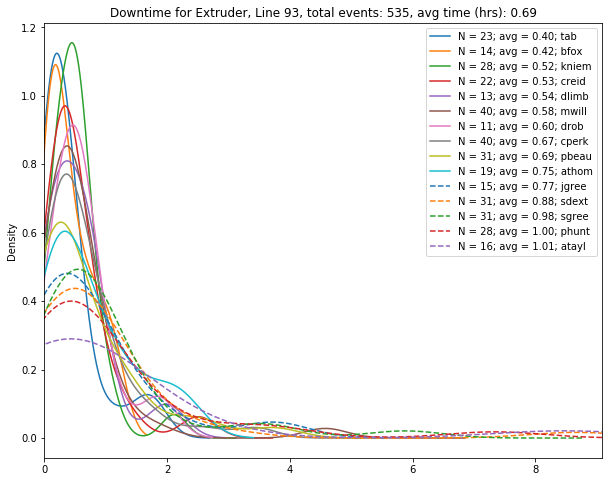

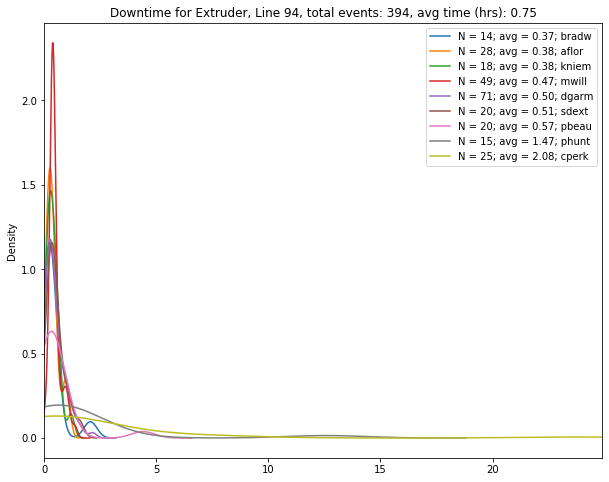

In [60]:
cat_of_interest = ["Form Station", "Form Tool", "Extruder"]
current = cat_of_interest[2] #current = "Former Mechanical"
focused = event.loc[event["category"] == current]
line_filter = None #'Line 33'
if line_filter:
    focused = focused.loc[focused['line'] == line_filter]
unique_inner_cutoff = 10
inner_var = 'user' # 'user' or 'part'
outer_var = 'line' # 'line' or 'reason'

for out_index, outer_reason in enumerate(focused[outer_var].unique()):
    to_plot = pd.DataFrame()
    outN = focused.loc[focused[outer_var] == outer_reason].shape[0]
    outAvg = np.average(focused.loc[focused[outer_var] == outer_reason]['hrs'])
    counter = 0
    for index, inner_reason in enumerate(focused.loc[focused[outer_var] == outer_reason][inner_var].unique()):
        df = focused.loc[(focused[outer_var] == outer_reason) & (focused[inner_var] == inner_reason)]
        N = df.shape[0]
        mean = np.average(df['hrs'])
        if N > unique_inner_cutoff:
            counter += 1
            df['average'] = mean
            to_plot = pd.concat([to_plot, df])
            label = "N = {}; avg = {:.2f}; {}".format(N, mean, inner_reason)
    if to_plot.shape[0] > 1:
        if to_plot[inner_var].unique().shape[0] > 2:
            fig, ax = plt.subplots(1,1,figsize=(10,8))
            to_plot.sort_values(by='average', inplace=True)
            for index, inner_reason in enumerate(to_plot.loc[to_plot[outer_var] == outer_reason][inner_var].unique()):
                subplot = to_plot.loc[(to_plot[outer_var] == outer_reason) & (to_plot[inner_var] == inner_reason)]
                N = subplot.shape[0]
                mean = np.average(subplot['hrs'])
                label = "N = {}; avg = {:.2f}; {}".format(N, mean, inner_reason)
                if index < 10:
                    subplot['hrs'].plot.kde(ax=ax, label=label)
                else:
                    subplot['hrs'].plot.kde(ax=ax, label=label, ls='--')
            if line_filter:
                plt.title("Downtime for {}, {}, {}, total events: {}, avg time (hrs): {:.2f}".format(
                    line_filter, current, outer_reason, outN, outAvg))
            else:
                plt.title("Downtime for {}, {}, total events: {}, avg time (hrs): {:.2f}".format(current, outer_reason, outN, outAvg))
            plt.legend()
            ax.set_xlim(0, max(to_plot['hrs']*1.05))
#             if line_filter:
#                 fig.savefig('../figures/kp_featherstone/{} {} {}'.format(line_filter, current, outer_reason))
#             elif current == outer_reason:
#                 fig.savefig('../figures/kp_featherstone/all lines {}'.format(outer_reason))
#             else:
#                 fig.savefig('../figures/kp_featherstone/{} {}'.format(current, outer_reason))

# Beta Plot

In [20]:
import weibull

In [93]:
delimiters = ['Stop Category', 'Stop Reason', 'Stop User', 'Line']
delimiter = delimiters[0]
beta_master = master.groupby(delimiter).filter(lambda x : (x[delimiter].count() >= 2).any())
quartiles = beta_master.groupby(delimiter)['Duration'].describe()
xsize=ysize=5
beta_table = np.zeros((beta_master[delimiter].unique().shape[0]))
beta_table = pd.DataFrame()
for index, item in enumerate(beta_master[delimiter].unique()):
    downtime_durations = beta_master.loc[beta_master[delimiter] == item]["Duration"]
    weibull_analysis = weibull.Analysis(downtime_durations.loc[downtime_durations > 0], unit='hour')
    if downtime_durations.shape[0] > 10:
        method='mle'
    else:
        method='lr'
    weibull_analysis.fit(method=method)
#     beta_table[index] = weibull_analysis.stats['beta nominal']
    beta_table = pd.concat([beta_table, weibull_analysis.stats])

In [76]:
beta_df = pd.DataFrame(beta_table)
beta_df.index = beta_master[delimiter].unique()

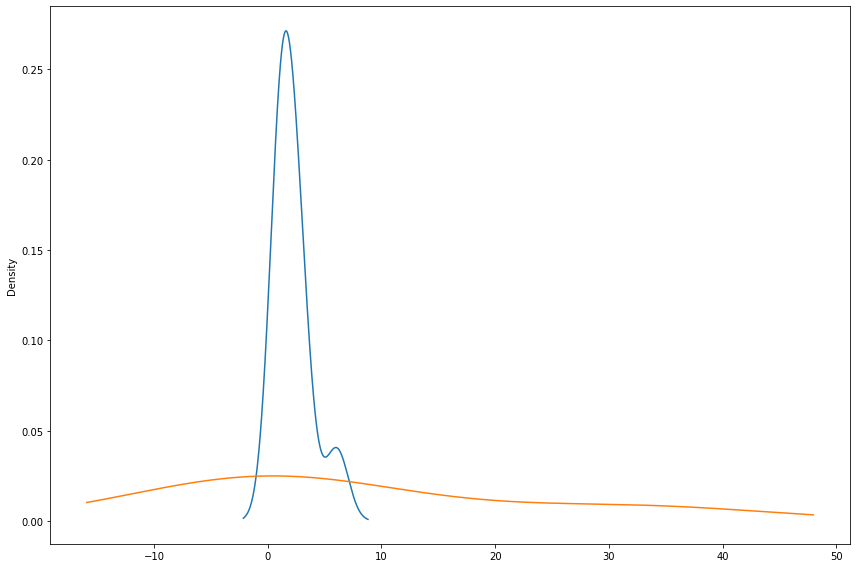

In [95]:
fig, ax = plt.subplots(1,1)
master.loc[master[delimiter] == 'Effluent water system']['Duration'].plot.kde(ax=ax)
master.loc[master[delimiter] == 'Auto packer']['Duration'].plot.kde(ax=ax)

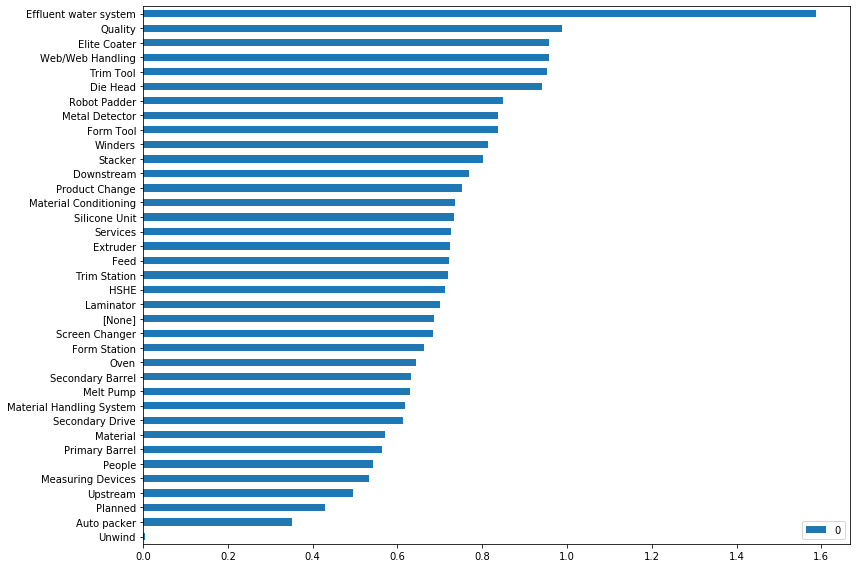

In [80]:
beta_df.sort_values(by=0).plot.barh()

# Moods Median Test

In [216]:
import scipy
import random

In [393]:
delimiters = ['Stop Category', 'Stop Reason', 'Stop User', 'Line']
delimiter = delimiters[2]
grouped = master.groupby(delimiter)['Duration']
x = grouped.apply(list)
pop = np.random.choice((np.concatenate(x)), int(1e3))

In [394]:
moods_table = pd.DataFrame()
for i in range(len(x)):
    stat, p, m, table = scipy.stats.median_test(x[i], pop)
    moods_table = pd.concat([moods_table, pd.DataFrame([x.index[i], stat, p, m, table]).T])

In [395]:
moods_table.columns = ['delimiter', 'pearsons', 'p_value', 'grand_median', 'table']
moods_table.set_index('delimiter', inplace=True)

In [397]:
moods_table.sort_values('p_value')

,pearsons,p_value,grand_median,table
delimiter,,,,
rjohn,383.971,1.69958e-85,0.133611,"[[379, 331], [41, 669]]"
dmart,370.503,1.45412e-82,0.144167,"[[531, 306], [144, 694]]"
lcarr,349.375,5.79713e-78,0.135556,"[[448, 323], [97, 677]]"
dgarm,346.803,2.10529e-77,0.145833,"[[606, 300], [213, 700]]"
rston,341.085,3.70371e-76,0.13625,"[[471, 322], [115, 678]]"
sdext,323.768,2.18906e-72,0.151111,"[[742, 294], [333, 706]]"
mwill,316.447,8.60662e-71,0.139722,"[[552, 316], [185, 684]]"
dlimb,311.678,9.41283e-70,0.136111,"[[515, 322], [160, 678]]"
gridg,299.805,3.63201e-67,0.1175,"[[318, 359], [37, 641]]"


# Lost Opportunity with Quantile Selection and Crow-AMSAA Prediction

In [ ]:
# key variables
# metric (rate, yield, downtime (uptime))

In [7]:
asset_metric = 'Rate'
line = "Line 95"
groupby = 'Product'
analysis = AssetCapability()
analysis.filter(rate_analysis, 
                line=line, 
                groupby=groupby,
                minn=0.01,
                maxx=0.83,
                top_filter=30,
                cut=3,
                yaxis=asset_metric)
analysis.opportunity_table()
print(analysis.table.name)

dff = analysis.table
yaxis = analysis.yaxis
metric = "max"
T1 = (dff["Run Time"]).dt.total_seconds()/60/60/24
P1 = (dff["Net Quantity Produced"])
if yaxis == "Rate":
    R1 = dff["50%"]
    R2 = dff[metric]
    dayssaved = ((dff["Net Quantity Produced"] / dff["50%"] / 24) - (dff["Net Quantity Produced"] / dff[metric] / 24)).sum()
    additionalproduction = ((R2-R1)*24 * T1).sum()
elif yaxis == "Yield":
    T2 = ((dff["Run Time"] * dff["mean"] / dff[metric])).dt.total_seconds()/60/60/24
    P2 = (dff["Net Quantity Produced"] * dff[metric]).sum()
    P1 = (dff["Net Quantity Produced"] * dff["50%"]).sum()
    dayssaved = (T1 - T2).sum()
    additionalproduction = P2 - P1
elif yaxis == "Unscheduled Downtime":
    if metric == "75%":
        metric = "25%"
    elif metric == "max":
        metric = "min"
    sched_time = dff["Run Time"] / (1 - dff["50%"])
    T2 = (sched_time * (1 - dff[metric])).dt.total_seconds()/60/60/24
    dayssaved = (T2 - T1).sum()
    P1 = (dff["Net Quantity Produced"])
    P2 = (T2 * P1 / T1)
    additionalproduction = (P2 - P1).sum()
elif yaxis == "Net Quantity Produced":
    additionalproduction = P1.sum()
    dayssaved = T1.sum()

print("additional runtime (days): {:.2f}".format(dayssaved))
print("additional production (kg): {:.2f}".format(additionalproduction))
print("additional production (%): {:.2f}".format(additionalproduction / P1.sum() * 100))
print('')

metric: Rate, by: Product, for: Line 95
additional runtime (days): 29.13
additional production (kg): 779815.40
additional production (%): 25.95



In [8]:
analysis.table

,count,mean,std,min,25%,50%,75%,max,Net Quantity Produced,Run Time
Product,,,,,,,,,,
1017705,148.0,941.777027,178.566736,190.000000,850.75,1053.0,1067.00,1074.000000,19340.0,1 days 01:00:00
1017669,152.0,936.967105,186.821954,220.000000,908.25,987.5,1060.00,1069.000000,8693.0,0 days 11:00:00
1020056,574.0,901.849200,177.895488,186.000000,835.00,912.0,1053.00,1083.000000,100353.0,5 days 07:05:40
1019089,252.0,885.302892,168.737082,140.000000,860.00,957.0,967.00,1043.000000,21315.0,1 days 02:26:27
1017695,495.0,878.265794,172.199838,136.752137,835.00,850.0,1051.00,1222.000000,168835.0,8 days 17:05:11
1020284,278.0,823.809402,127.163549,120.000000,820.75,845.0,859.75,1054.000000,67543.0,3 days 08:58:23
1018944 A,452.0,819.681779,158.927346,115.989160,830.00,846.5,910.25,1034.000000,165064.0,8 days 16:52:22
1020285,286.0,818.566066,147.189154,180.000000,750.50,840.5,941.75,980.000000,65132.0,3 days 10:40:35
1028567,175.0,817.935456,113.798288,260.000000,830.00,843.0,850.00,994.000000,41735.0,2 days 01:32:17


In [ ]:
minimum_events = 5
master = pd.DataFrame()

for reason in quartiles.index:
    lost_opportunity = event.loc[(event["length"] > quartiles.loc[reason, "75%"]) & 
              (event["reason"] == reason) & 
              (event["time"] > pd.Timestamp(year=2019, month=1, day=1))]
    lost_opportunity = lost_opportunity.reset_index(drop=True)
    if lost_opportunity.shape[0] > minimum_events:
        TTF = pd.to_datetime(lost_opportunity['time']) - pd.to_datetime(lost_opportunity['time'].shift())
        TTF = TTF.dt.total_seconds()/60/60
        weibull_analysis = weibull.Analysis(TTF, unit='hour')
        if TTF.shape[0] > 20:
            weibull_analysis.fit(method='mle')
        else:
            weibull_analysis.fit(method='lr')
        print(reason)
        print('beta: {:.2f}'.format(weibull_analysis.stats['beta nominal']))
        print('')